## Testing the Rating System

Let's generate some bernoulli based data based on my soon to be rating model and see if we can recover the parameters

In [87]:
import pandas as pd
import numpy as np
from scipy.stats import norm, bernoulli
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

Generate teams and Data with timevarying skill

In [281]:
true_team_skill = {
    'A': [[1200, 100], [1300, 90], [1650, 150]],
    'B': [[1100, 200], [1100, 200], [1200, 200]],
    'C': [[800, 100], [1100, 300], [500, 120]],
    'D': [[850, 120], [700, 500], [1200, 500]],
    'E': [[700, 500], [400, 800], [900, 600]],
}
beta = 50

num_matches = 1000
n_teams = len(true_team_skill)

match_ups = np.random.choice(list(true_team_skill.keys()), (num_matches, 2), p=[0.1, 0.25, 0.25, 0.35, 0.05])
match_ups = match_ups[match_ups[:,0] != match_ups[:,1]]
print("%i Number of Generated Matchups" % len(match_ups))

num_matches = len(match_ups)
p_time = np.round(np.array([0.2, 0.5, 0.3])*num_matches).astype(int)
t = np.array([0]*p_time[0] + [1]*p_time[1] + [2]*p_time[2])
print("%s Time set matches -- 0: %i  1: %i  2: %i" % ((len(t),)+tuple(t for t in p_time)))

match_ups = np.column_stack([match_ups,t])

718 Number of Generated Matchups
718 Time set matches -- 0: 144  1: 359  2: 215


Now let's generate three set of time seried matches

In [282]:

winner = []
for match in match_ups:
    param_one = true_team_skill[match[0]][int(match[2])]
    param_two = true_team_skill[match[1]][int(match[2])]
    
    p_one = 1.-norm.cdf(0, loc=param_one[0]-param_two[0], scale=np.sqrt(param_one[1]**2 + param_two[1]**2 + 2*beta**2))
    res = bernoulli.rvs(p_one)
    #print('%s vs %s - p: %.1f - %s won' % (match[0], match[1], p_one*100., match[int(np.logical_not(res))]))
    winner.append(match[int(np.logical_not(res))])

In [283]:
obs = pd.DataFrame(match_ups, columns=['Team 1', 'Team 2', 't'])
obs['t'] = obs['t'].astype(int)
obs['winner'] = winner
obs.head()

,Team 1,Team 2,t,winner
0,E,B,0,B
1,B,C,0,B
2,D,B,0,D
3,D,B,0,B
4,C,D,0,D


## Non-MCMC Model

In [300]:
def vec2dict(s, n_teams, n_periods):
    return {
        'mu': np.array(s[:n_teams]),
        'sigma': np.array(s[n_teams:n_teams*2]),
        'alpha': np.array(s[n_teams*2:n_periods*n_teams+n_teams*2]).reshape(n_periods, n_teams),
        'beta': s[-2],
        'omega': s[-1]
    }

def dict2vec(s):
    return s['mu'].tolist()+s['sigma'].tolist()+s['alpha'].flatten().tolist()+[s['beta'], s['omega']]

In [319]:
skills_0 = dict2vec({
    'mu': np.array([1000]*n_teams),
    'sigma': np.array([150]*n_teams),
    'alpha': np.zeros(shape=(n_periods, n_teams)),
    'beta': 50,
    'omega': 150,
})

In [322]:
from scipy.optimize import minimize

n_periods = obs['t'].max()
mapping = {v:k for k,v in dict(enumerate(['A', 'B', 'C', 'D', 'E'])).items()}


def loglike(y,p):
    return -1.*(np.sum(y*np.log(p)+(1.-y)*np.log(1-p)))

def obj(skills):
    s = vec2dict(skills, n_teams, n_periods)
    ll = 0
    
    for i in range(n_periods+1):
        obs_per = obs[obs['t'] == i]
        
        s['mu'] = s['mu'] + s['alpha'][i-1] if i > 0 else s['mu']
        sigma_sq = sigma_sq + s['omega']**2 if i > 0 else s['sigma']**2
        
        mean_diff = s['mu'][obs_per['Team 1'].map(mapping).values] - s['mu'][obs_per['Team 2'].map(mapping).values]
        var_diff = sigma_sq[obs_per['Team 1'].map(mapping).values] + sigma_sq[obs_per['Team 2'].map(mapping).values] + 2.*s['beta']**2
        
        p = 1.-norm.cdf(0., loc=mean_diff, scale = np.sqrt(var_diff))
        ll += loglike((obs_per['Team 1'] == obs_per['winner']).values, p)
        
    return ll


In [323]:
obj(skills_0)

497.67967564204071

In [328]:
g = minimize(obj, x0=skills_0, constraints = {'type': 'ineq', 'fun': lambda x: x[5:10]})
print(g.message)
print(g.fun)

Iteration limit exceeded
341.6133274895941


{'mu': array([ 1229.79853781,  1192.12052948,   847.08480906,   940.57869453,
         790.526306  ]), 'sigma': array([  2.20166613e+01,   1.77635684e-15,   1.25315339e+02,
         3.39778753e+02,   4.01692057e+02]), 'alpha': array([[  1.78403179e-01,  -8.86145432e+01,   2.22484084e+02,
         -1.03766242e+02,  -3.02994712e+01],
       [  1.93030913e+02,  -8.15024851e+01,  -4.36590600e+02,
          2.48655234e+02,   7.64650616e+01]]), 'beta': 75.71750584695485, 'omega': -4.2690783372273202}


C:\Users\kevin.pei\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
C:\Users\kevin.pei\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


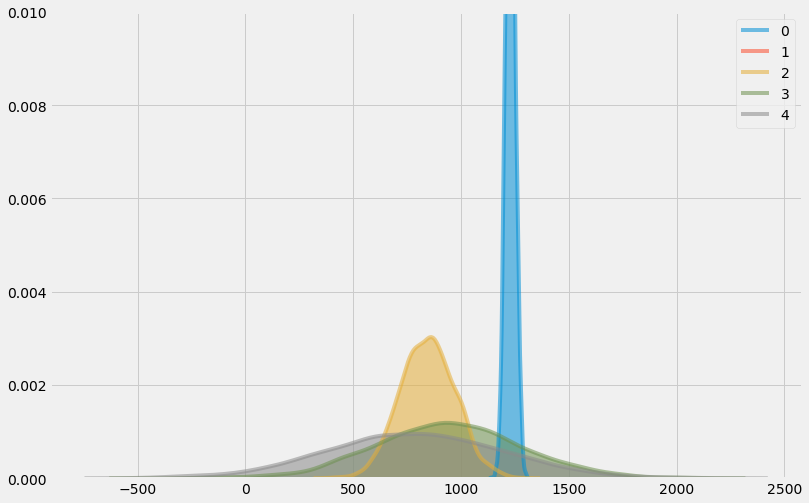

In [329]:
opt_skill = vec2dict(g.x, n_teams, n_periods)
print(opt_skill)
plots = norm.rvs(opt_skill['mu'], opt_skill['sigma'], size=(5000,5))

f, ax = plt.subplots(figsize=(12,8))
plt.ylim(0,0.01)
[sns.kdeplot(plots[:,i], shade=True, alpha=0.55, legend=True, ax=ax, label=i) for i in range(5)]

In [330]:
cur_skill = opt_skill['mu']
skill_over_time = [opt_skill['mu']]
for i in range(n_periods):
    skill_over_time.append(cur_skill*opt_skill['alpha'][i])

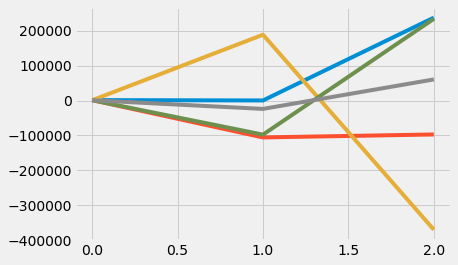

In [333]:
plt.plot(np.stack(skill_over_time))

In [245]:
skill_over_time

[array([ 1212.22982073,  1103.98496928,   864.83442527,   864.50391771,
          954.02637907]),
 array([ 860.46999493,  760.9401195 ,  784.6136615 ,  618.78188362,
         614.0004628 ]),
 array([-28183.97130012, -29498.07069969, -22833.65284515, -28269.84121511,
        -31633.64917438])]

In [548]:
infer_mean = opt_skill[:5]
infer_std = opt_skill[5:-1]
infer_beta = opt_skill[-1]

err = {'mcmc': [], 'opt': []}
for pair, k in obs.groupby(['Team 1', 'Team 2']).count().itertuples():
    param_one = true_team_skill[pair[0]]
    param_two = true_team_skill[pair[1]]
    
    p_one_true = 1.-norm.cdf(0, loc=param_one[0]-param_two[0], scale=np.sqrt(param_one[1]**2 + param_two[1]**2 + 50.**2))
    p_one_opt = 1.-norm.cdf(0, loc=infer_mean[mapping[pair[0]]]-infer_mean[mapping[pair[1]]], scale=np.sqrt(infer_std[mapping[pair[0]]]**2 + infer_std[mapping[pair[1]]]**2 + infer_beta**2))
    p_one_mcmc = (1./(1+np.exp(-0.005*(trace['rating'][:,mapping[pair[0]]] - trace['rating'][:,mapping[pair[1]]])))).mean()
    
    err['mcmc'].append(p_one_true-p_one_mcmc); err['opt'].append(p_one_true-p_one_opt);
    
    print('%s vs %s : true - %.2f pct   |   optim - %.2f pct   |   mcmc - %.2f pct' % 
          (pair[0], pair[1], p_one_true*100., p_one_opt*100., p_one_mcmc*100.))

A vs B : true - 66.87 pct   |   optim - 70.94 pct   |   mcmc - 67.31 pct
A vs C : true - 99.62 pct   |   optim - 96.90 pct   |   mcmc - 92.87 pct
A vs D : true - 98.36 pct   |   optim - 95.54 pct   |   mcmc - 89.55 pct
A vs E : true - 83.54 pct   |   optim - 82.40 pct   |   mcmc - 91.68 pct
B vs A : true - 33.13 pct   |   optim - 29.06 pct   |   mcmc - 32.69 pct
B vs C : true - 90.48 pct   |   optim - 88.91 pct   |   mcmc - 86.32 pct
B vs D : true - 85.27 pct   |   optim - 84.12 pct   |   mcmc - 80.59 pct
B vs E : true - 77.02 pct   |   optim - 74.07 pct   |   mcmc - 84.26 pct
C vs A : true - 0.38 pct   |   optim - 3.10 pct   |   mcmc - 7.13 pct
C vs B : true - 9.52 pct   |   optim - 11.09 pct   |   mcmc - 13.68 pct
C vs D : true - 38.02 pct   |   optim - 35.98 pct   |   mcmc - 39.81 pct
C vs E : true - 57.74 pct   |   optim - 52.02 pct   |   mcmc - 46.16 pct
D vs A : true - 1.64 pct   |   optim - 4.46 pct   |   mcmc - 10.45 pct
D vs B : true - 14.73 pct   |   optim - 15.88 pct   |   m

In [549]:
np.mean(np.power(err['mcmc'],2))

0.0044335779687110447

In [550]:
np.mean(np.power(err['opt'],2))

0.00093468368325839882

## Pymc Modelling

In [7]:
import pymc3 as pm
import theano.tensor as tt

In [13]:
mapping = {v:k for k,v in dict(enumerate(['A', 'B', 'C', 'D', 'E'])).items()}
with pm.Model() as rating_model:
    
    beta = pm.Uniform('beta', 30., 50.)
    skills = pm.Normal('rating', 1000., 150., shape=n_teams)
    performance = pm.Normal('performance', skills, beta, shape=n_teams)    
    
    diff = performance[obs['Team 1'].map(mapping).values] - performance[obs['Team 2'].map(mapping).values]
    p = tt.nnet.sigmoid(0.005*diff)
    
    err = pm.DensityDist('observed', lambda x: tt.sum(x*tt.log(p)+(1.-x)*tt.log(1-p)), observed=(obs['Team 1'] == obs['winner']).values)
    #err = pm.Bernoulli('observed', p=p, observed=(obs['Team 1'] == obs['winner']).values)

In [ ]:
with rating_model:
    #start = pm.find_MAP()
    trace = pm.sample(10000, tune=0) #step=pm.Metropolis(), start=start, 

In [ ]:
pm.traceplot(trace)
pm.plot_posterior(trace)

In [538]:
infer_mean = trace['rating'].mean(axis=0)
infer_std = trace['rating'].std(axis=0)
for pair, k in obs.groupby(['Team 1', 'Team 2']).count().itertuples():
    param_one = true_team_skill[pair[0]]
    param_two = true_team_skill[pair[1]]
    
    p_one_true = 1.-norm.cdf(0, loc=param_one[0]-param_two[0], scale=np.sqrt(param_one[1]**2 + param_two[1]**2 + beta**2))
    p_one_infer = (1./(1+np.exp(-0.005*(trace['rating'][:,mapping[pair[0]]] - trace['rating'][:,mapping[pair[1]]])))).mean()
    #p_one_infer = 1.-norm.cdf(0, loc=infer_one[0]-infer_two[0], scale=np.sqrt(infer_one[1]**2 + infer_two[1]**2 + 50.**2))
    print('%s vs %s : true - %.2f pct   |   infer - %.2f pct' % (pair[0], pair[1], p_one_true*100., p_one_infer*100.))

A vs B : true - 66.87 pct   |   infer - 67.31 pct
A vs C : true - 99.62 pct   |   infer - 92.87 pct
A vs D : true - 98.36 pct   |   infer - 89.55 pct
A vs E : true - 83.54 pct   |   infer - 91.68 pct
B vs A : true - 33.13 pct   |   infer - 32.69 pct
B vs C : true - 90.48 pct   |   infer - 86.32 pct
B vs D : true - 85.27 pct   |   infer - 80.59 pct
B vs E : true - 77.02 pct   |   infer - 84.26 pct
C vs A : true - 0.38 pct   |   infer - 7.13 pct
C vs B : true - 9.52 pct   |   infer - 13.68 pct
C vs D : true - 38.02 pct   |   infer - 39.81 pct
C vs E : true - 57.74 pct   |   infer - 46.16 pct
D vs A : true - 1.64 pct   |   infer - 10.45 pct
D vs B : true - 14.73 pct   |   infer - 19.41 pct
D vs C : true - 61.98 pct   |   infer - 60.19 pct
D vs E : true - 61.42 pct   |   infer - 56.39 pct
E vs A : true - 16.46 pct   |   infer - 8.32 pct
E vs B : true - 22.98 pct   |   infer - 15.74 pct
E vs C : true - 42.26 pct   |   infer - 53.84 pct
E vs D : true - 38.58 pct   |   infer - 43.61 pct
